# Visualization notebook

In [2]:
## Imports
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seawater as sw
import cmocean.cm as cmo
from scipy import integrate
from scipy.interpolate import griddata
import sys

## Load total dataframe (this takes ~30 seconds)

In [3]:
tot_transect_df = pd.read_csv('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/AOML_data_subset_transects.csv')

In [4]:
tot_transect_df

,ctd_time,ctd_pressure,aanderaa4831_dissolved_oxygen_shifted,downs,longitude,latitude,temperature,salinity,density,aanderaa4831_dissolved_oxygen,du,dv,su,sv,time_shift,transect_number,deployment_name
0,2015-02-09 08:21:40,1.278298,192.300091,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,1,SG609-M02FEB2015
1,2015-02-09 08:21:49,1.321579,192.386667,1.0,-67.465350,17.555617,26.974641,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
2,2015-02-09 08:21:59,1.778545,192.418361,1.0,-67.465350,17.555612,26.975472,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
3,2015-02-09 08:22:18,3.029667,192.387976,1.0,-67.465349,17.555604,26.984981,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
4,2015-02-09 08:22:28,4.100253,192.504311,1.0,-67.465302,17.555602,26.994143,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10807892,2022-07-07 14:08:22,13.041327,241.704636,0.0,-65.033142,17.011794,28.242144,34.262031,1021.762859,241.776639,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807893,2022-07-07 14:08:31,11.730388,241.883389,0.0,-65.033147,17.011787,28.254553,34.259990,1021.757259,241.690682,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807894,2022-07-07 14:08:42,10.016299,242.055362,0.0,-65.033152,17.011778,28.258000,34.259422,1021.755703,241.742825,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807895,2022-07-07 14:08:52,8.443124,241.966350,0.0,-65.033155,17.011770,28.257050,34.258350,1021.755209,241.782111,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022


## Split transects into north and south

In [5]:
north_transect_df = tot_transect_df[(tot_transect_df.latitude.values > 18.35)]
south_transect_df = tot_transect_df[(tot_transect_df.latitude.values < 18.35)]

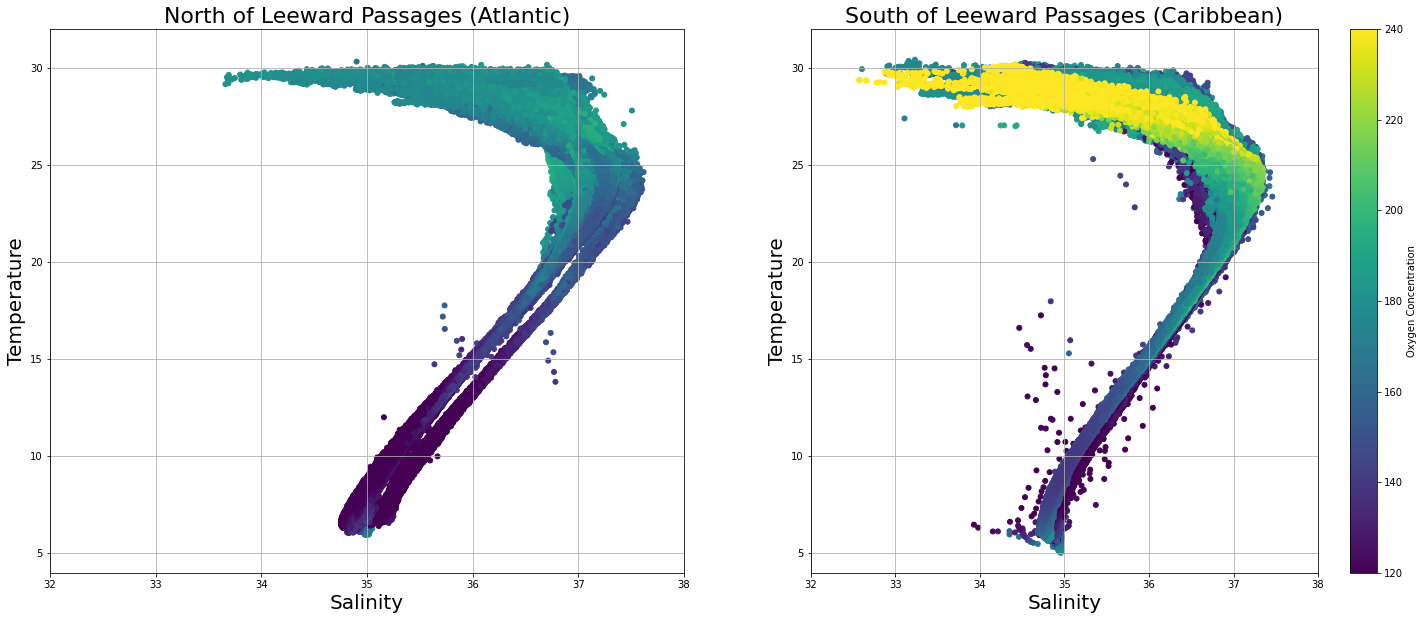

In [6]:
fig, ax = plt.subplots(1,2, figsize=(25,10))


######### Plot settings #########
## Plot ever increment points
increment = 10
## Font size
font_size = 20
## Title size
title_size = 22
## markersize
markersize = 25
## colorbar range
vmin = 120
vmax = 240

ax[0].scatter(north_transect_df.salinity.values[::increment],north_transect_df.temperature.values[::increment],c=north_transect_df.aanderaa4831_dissolved_oxygen_shifted.values[::increment],vmin=vmin,vmax=vmax,s=markersize)
ax[0].set_xlim(32,38)
ax[0].set_ylim(4,32)
ax[0].set_xlabel('Salinity', size=font_size)
ax[0].set_ylabel('Temperature', size=font_size)
ax[0].set_title('North of Leeward Passages (Atlantic)', size=title_size)
ax[0].grid()

im = ax[1].scatter(south_transect_df.salinity.values[::increment],south_transect_df.temperature.values[::increment],c=south_transect_df.aanderaa4831_dissolved_oxygen_shifted.values[::increment],vmin=vmin,vmax=vmax,s=markersize)
ax[1].set_xlim(32,38)
ax[1].set_ylim(4,32)
ax[1].set_xlabel('Salinity', size=font_size)
ax[1].set_ylabel('Temperature', size=font_size)
ax[1].set_title('South of Leeward Passages (Caribbean)', size=title_size)
ax[1].grid()

fig.colorbar(im, label='Oxygen Concentration')


Text(0.5, 1.0, 'AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')

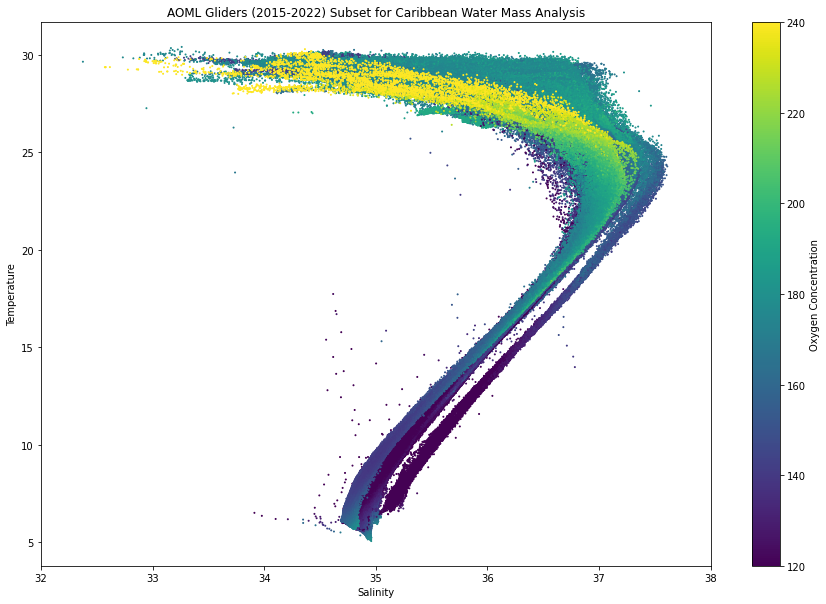

In [7]:
increment = 10


plt.figure(figsize=(15,10))
plt.scatter(tot_transect_df.salinity.values[::10],tot_transect_df.temperature.values[::10],c=tot_transect_df.aanderaa4831_dissolved_oxygen_shifted.values[::10],vmin=120,vmax=240,s=1)
plt.colorbar(label='Oxygen Concentration')
plt.xlim(32,38)
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')


Text(0.5, 1.0, 'AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')

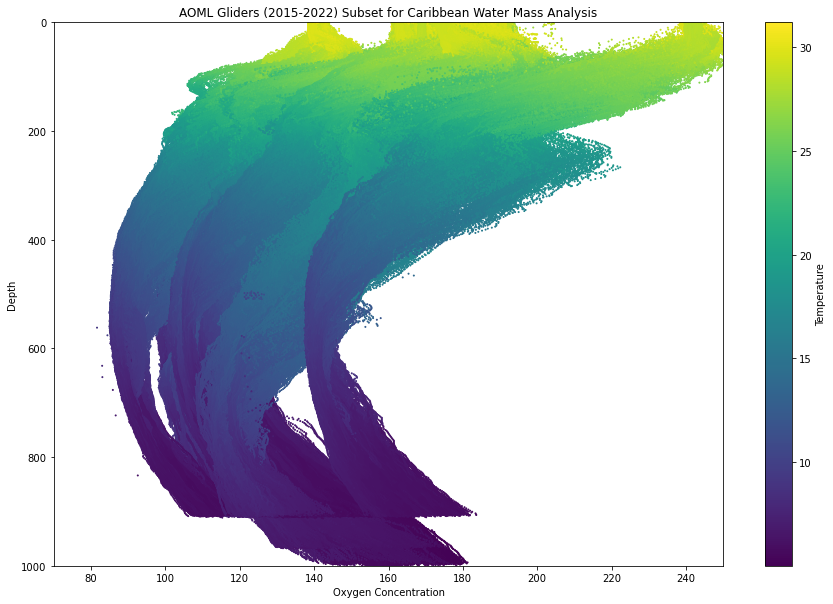

In [8]:
plt.figure(figsize=(15,10))
plt.scatter(tot_transect_df.aanderaa4831_dissolved_oxygen_shifted.values,tot_transect_df.ctd_pressure.values,c=tot_transect_df.temperature.values,s=1)
plt.colorbar(label='Temperature')
plt.ylim(1000,0)
plt.xlim(70,250)
plt.xlabel('Oxygen Concentration')
plt.ylabel('Depth')
plt.title('AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')


## Now make some plots with the transport data

### Just "normal" north versus south transport

In [10]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

transport_north = np.empty(len(transport_files))
transport_north[:] = np.nan
transport_north_tm = np.empty(len(transport_files),dtype='datetime64[s]')

transport_south = np.empty(len(transport_files))
transport_south[:] = np.nan
transport_south_tm = np.empty(len(transport_files),dtype='datetime64[s]')


for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    if ds.latitude.mean() > 18.35:
        transport_north[x] = np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6)
        transport_north_tm[x] = ds.mid_time.values
        ds.close()
    else:
        transport_south[x] = np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6)
        transport_south_tm[x] = ds.mid_time.values
        ds.close()



In [11]:
np.nanmean(transport_south)

-5.186056008830511

In [12]:
np.nanmean(transport_north)

-12.12187242729278

(-30.0, 30.0)

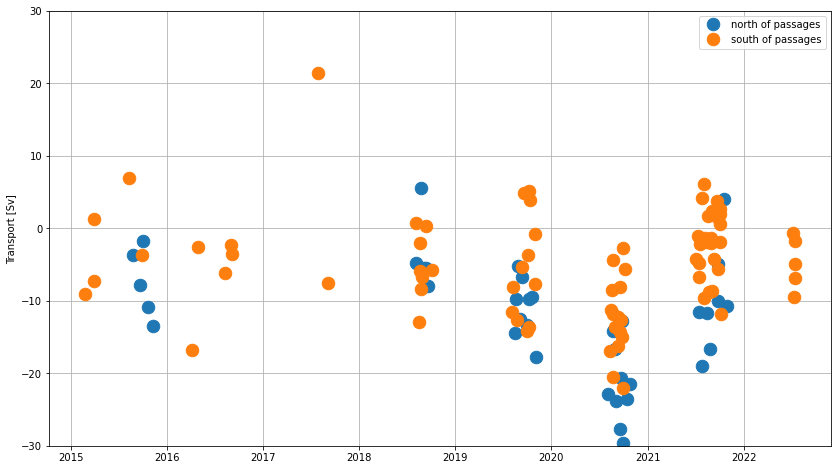

In [13]:
plt.figure(figsize=(14,8))
plt.plot(transport_north_tm,transport_north,'.',label='north of passages',markersize=25)
plt.plot(transport_south_tm,transport_south,'.',label='south of passages',markersize=25)
plt.legend()
plt.grid()
plt.ylabel('Transport [Sv]')
plt.ylim(-30,30)


### Now transport standardized *per* transect length

In [14]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

transport_north = np.empty(len(transport_files))
transport_north[:] = np.nan
transport_north_tm = np.empty(len(transport_files),dtype='datetime64[s]')

transport_south = np.empty(len(transport_files))
transport_south[:] = np.nan
transport_south_tm = np.empty(len(transport_files),dtype='datetime64[s]')


for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    if ds.latitude.mean() > 18.35:
        transport_north[x] = (np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6))/ds.attrs['transect_dist']
        transport_north_tm[x] = ds.mid_time.values
        ds.close()
    else:
        transport_south[x] = (np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6))/ds.attrs['transect_dist']
        transport_south_tm[x] = ds.mid_time.values
        ds.close()



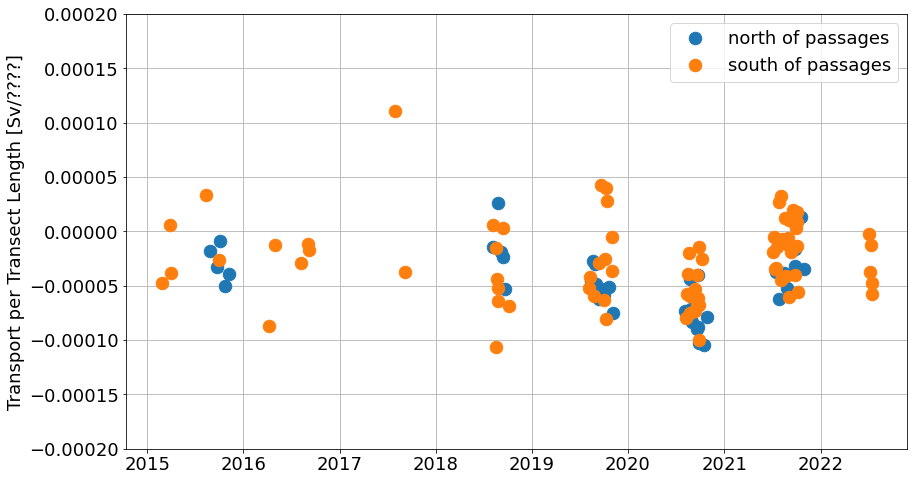

In [15]:
plt.figure(figsize=(14,8))
plt.plot(transport_north_tm,transport_north,'.',label='north of passages',markersize=25)
plt.plot(transport_south_tm,transport_south,'.',label='south of passages',markersize=25)
plt.legend(prop={'size': 18})
plt.grid()
plt.ylabel('Transport per Transect Length [Sv/????]',size=18)
plt.ylim(-0.0002,0.0002)
plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)
#plot.legend(loc=2, prop={'size': 6})



### Now transport across a specified latitude from north and south

In [16]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

transport_north = np.empty(len(transport_files))
transport_north[:] = np.nan
transport_north_tm = np.empty(len(transport_files),dtype='datetime64[s]')

transport_south = np.empty(len(transport_files))
transport_south[:] = np.nan
transport_south_tm = np.empty(len(transport_files),dtype='datetime64[s]')


for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    if ds.latitude.mean() > 18.35:
        subset_ds = ds.sel(latitude=slice(19.85,20.15))
        transport_north[x] = np.nansum(subset_ds.Vgeo.values*subset_ds.attrs['geo_dz']*subset_ds.attrs['dy'])/(10**6)
        transport_north_tm[x] = ds.mid_time.values
        ds.close()
    else:
        subset_ds = ds.sel(latitude=slice(16.85,17.15))
        transport_south[x] = np.nansum(subset_ds.Vgeo.values*subset_ds.attrs['geo_dz']*subset_ds.attrs['dy'])/(10**6)        
        transport_south_tm[x] = ds.mid_time.values
        ds.close()

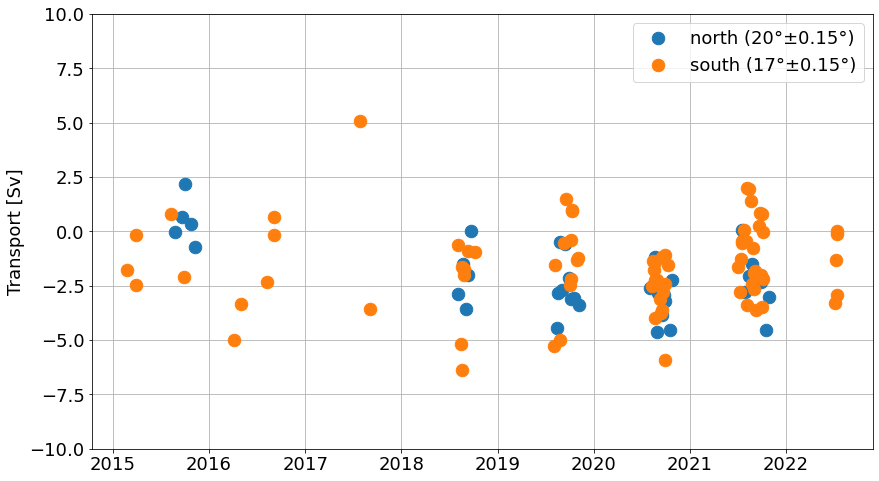

In [17]:
plt.figure(figsize=(14,8))
plt.plot(transport_north_tm,transport_north,'.',label='north (20°±0.15°)',markersize=25)
plt.plot(transport_south_tm,transport_south,'.',label='south (17°±0.15°)',markersize=25)
plt.legend(prop={'size': 18})
plt.grid()
plt.ylabel('Transport [Sv]',size=18)
plt.ylim(-10,10)
plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)



### Then integrate transport vertically and plot horizontal vectors from each transect on a map

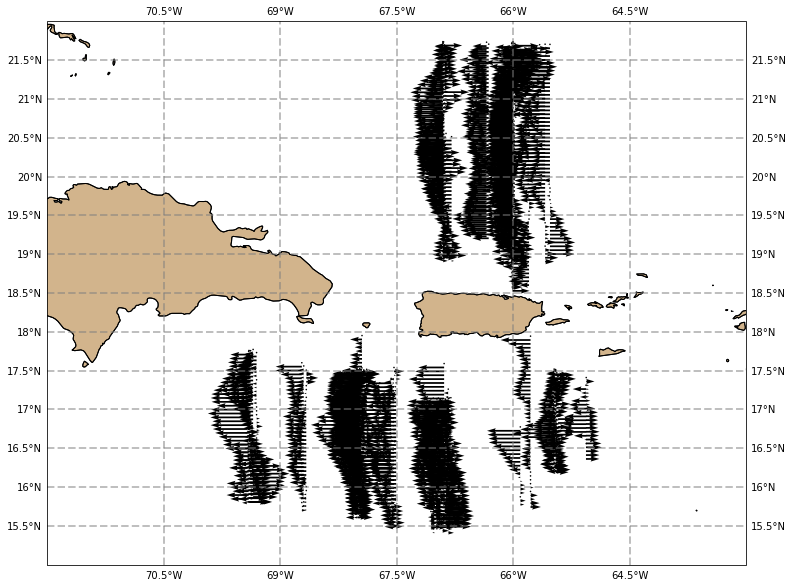

In [18]:
## Map extent
lon1 = -72
lon2 = -63
lat1 = 15
lat2 = 22

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.ylocator = mticker.FixedLocator([15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5])


## Now add to plot
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    lat_transports = (np.nansum(ds.Vgeo.values,axis=0)*ds.attrs['dy'])/(10**6)
    ax.quiver(np.repeat(ds.attrs['mean_lon'],len(ds.latitude.values)),ds.latitude.values,lat_transports,np.repeat(0,len(ds.latitude.values)),scale=1,width=0.0025, scale_units='inches',transform=ccrs.PlateCarree())
    ds.close()

